<a href="https://colab.research.google.com/github/nadolsw/Python/blob/master/Google_CoLab_UCIHAR_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#####################################################
###### UPLOAD LOCAL FILE TO WORKING DIRECTORY #######
#####################################################

#from google.colab import files
#uploaded = files.upload()

Saving data.zip to data.zip


In [0]:
# -*- coding: utf-8 -*-
"""
Created on Sun Jun 16 12:36:30 2019
@author: William Nadolski (winado)
Created based on the following tutorial: http://ataspinar.com/2018/04/04/machine-learning-with-signal-processing-techniques/
"""
##################################
### INSTALL NECESSARY PACKAGES ###
##################################

#If first time running then execute the following from OS command line
#Additional options are necessary for installing from within Jupyter

#import os
#import sys
#!{sys.executable} -m pip install --user siml
#!{sys.executable} -m pip install --user xgboost
#!{sys.executable} -m pip install --user seaborn
#!{sys.executable} -m pip install --user pywavelets
#!{sys.executable} -m pip install --user tensorflow-gpu
#!{sys.executable} -m pip install --user keras

  Created wheel for siml: filename=siml-0.2.1-cp36-none-any.whl size=19879 sha256=06f93967e15cf10b3c6f5d4ec7c5f41c94e16052784c470b0cf097f1c8706e19
  Stored in directory: /root/.cache/pip/wheels/f2/8d/36/68e58ff0a4b13cd5f2aa666139adf7213afb58781849b0044a
Successfully built siml


In [0]:
#################################
### IMPORT NECESSARY PACKAGES ###
#################################

import os
import sys
import time
import pywt
import numpy as np
import pandas as pd
import scipy as scipy
import scipy.io as sio
import matplotlib.pyplot as plt

#from siml import *
#from siml.sk_utils import *
from sklearn import *
from collections import Counter
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D
from sklearn import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from scipy import *
from scipy.signal import welch
from scipy.fftpack import fft
from scipy import signal
from scipy.fftpack import fft

from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier

import tensorflow as tf
from collections import Counter
from collections import defaultdict

#Check to see whether TF is utilizing GPU or CPU
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import keras
from keras.layers import Activation, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential
from keras.callbacks import History 
from keras.layers import LeakyReLU
history = History()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6873872299012265423
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2848116190829829927
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1592787733224157409
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14892338381
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3665123835179152131
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


Using TensorFlow backend.


In [0]:
#################################
#### CONNECT TO GOOGLE DRIVE ####
#################################

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
##########################
#### LIST DIRECTORIES ####
##########################

import glob
path = '/content/gdrive/My Drive/data/'
folders = [f for f in glob.glob(path + "**/", recursive=True)]
for f in folders:
    print(f)

/content/gdrive/My Drive/data/
/content/gdrive/My Drive/data/UCI HAR Dataset/
/content/gdrive/My Drive/data/UCI HAR Dataset/test/
/content/gdrive/My Drive/data/UCI HAR Dataset/test/Inertial Signals/
/content/gdrive/My Drive/data/UCI HAR Dataset/train/
/content/gdrive/My Drive/data/UCI HAR Dataset/train/Inertial Signals/


In [0]:
############################################
### DEFINE DATA IMPORT UTILITY FUNCTIONS ###
############################################

def read_signals_ucihar(filename):
    with open(filename, 'r') as fp:
        print("Reading in file: {}".format(fp))
        data = fp.read().splitlines()
        data = map(lambda x: x.rstrip().lstrip().split(), data)
        data = [list(map(float, line)) for line in data]
    return data

def read_labels_ucihar(filename):        
    with open(filename, 'r') as fp:
        activities = fp.read().splitlines()
        activities = list(map(int, activities))
    return activities
 
def load_ucihar_data(folder):
    train_folder = folder + 'train/Inertial Signals/'
    test_folder = folder + 'test/Inertial Signals/'
    labelfile_train = folder + 'train/y_train.txt'
    labelfile_test = folder + 'test/y_test.txt'
    train_signals, test_signals = [], []
    for input_file in sort(os.listdir(train_folder)):
        signal = read_signals_ucihar(train_folder + input_file)
        train_signals.append(signal)
    train_signals = np.transpose(np.array(train_signals), (1, 2, 0))
    for input_file in sort(os.listdir(test_folder)):
        signal = read_signals_ucihar(test_folder + input_file)
        test_signals.append(signal)
    test_signals = np.transpose(np.array(test_signals), (1, 2, 0))
    train_labels = read_labels_ucihar(labelfile_train)
    test_labels = read_labels_ucihar(labelfile_test)
    return train_signals, train_labels, test_signals, test_labels

def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation, :, :]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

In [0]:
#########################################
########## IMPORT HAR DATASETS ##########
#########################################

folder_ucihar = '/content/gdrive/My Drive/data/UCI HAR Dataset/' 
train_signals, train_labels, test_signals, test_labels = load_ucihar_data(folder_ucihar)

INPUT_SIGNAL_FILES = ['body_acc_x_train.txt', 'body_acc_y_train.txt', 'body_acc_z_train.txt', 
                     'body_gyro_x_train.txt', 'body_gyro_y_train.txt', 'body_gyro_z_train.txt',
                     'total_acc_x_train.txt', 'total_acc_y_train.txt', 'total_acc_z_train.txt']

[no_signals_train, no_steps_train, no_components_train] = np.shape(train_signals)
[no_signals_test, no_steps_test, no_components_test] = np.shape(test_signals)
no_labels = len(np.unique(train_labels[:])) #number of labels (activities)

print("Training dataset contains {} signals, each one of length {} and {} different components ".format(no_signals_train, no_steps_train, no_components_train))
print("Training labels have the following distribution:\n {}".format(Counter(train_labels[:])))
print("Test dataset contains {} signals, each one of length {} and {} different components ".format(no_signals_test, no_steps_test, no_components_test))
#print("Test labels have the following distribution:\n {}".format(Counter(test_labels[:])))

print("Activity labels originally have the following unique values:\n {}".format(unique(test_labels)))
#Need to ensure activity labels start at zero instead of one for later use in keras
train_labels[:] = [x - 1 for x in train_labels]
test_labels[:] = [x - 1 for x in test_labels]
print("Activity labels now have the following unique values:\n {}".format(unique(test_labels)))

#Define activity label key
activities_description = {
    0: 'walking',
    1: 'walking upstairs',
    2: 'walking downstairs',
    3: 'sitting',
    4: 'standing',
    5: 'laying'
}

#Shuffle data while retaining mapping with labels
train_signals, train_labels = randomize(train_signals, np.array(train_labels))
test_signals, test_labels = randomize(test_signals, np.array(test_labels))
print("Shuffling data!")

Reading in file: <_io.TextIOWrapper name='/content/gdrive/My Drive/data/UCI HAR Dataset/train/Inertial Signals/body_acc_x_train.txt' mode='r' encoding='UTF-8'>
Reading in file: <_io.TextIOWrapper name='/content/gdrive/My Drive/data/UCI HAR Dataset/train/Inertial Signals/body_acc_y_train.txt' mode='r' encoding='UTF-8'>
Reading in file: <_io.TextIOWrapper name='/content/gdrive/My Drive/data/UCI HAR Dataset/train/Inertial Signals/body_acc_z_train.txt' mode='r' encoding='UTF-8'>
Reading in file: <_io.TextIOWrapper name='/content/gdrive/My Drive/data/UCI HAR Dataset/train/Inertial Signals/body_gyro_x_train.txt' mode='r' encoding='UTF-8'>
Reading in file: <_io.TextIOWrapper name='/content/gdrive/My Drive/data/UCI HAR Dataset/train/Inertial Signals/body_gyro_y_train.txt' mode='r' encoding='UTF-8'>
Reading in file: <_io.TextIOWrapper name='/content/gdrive/My Drive/data/UCI HAR Dataset/train/Inertial Signals/body_gyro_z_train.txt' mode='r' encoding='UTF-8'>
Reading in file: <_io.TextIOWrapper n

Training Record Chosen: 100


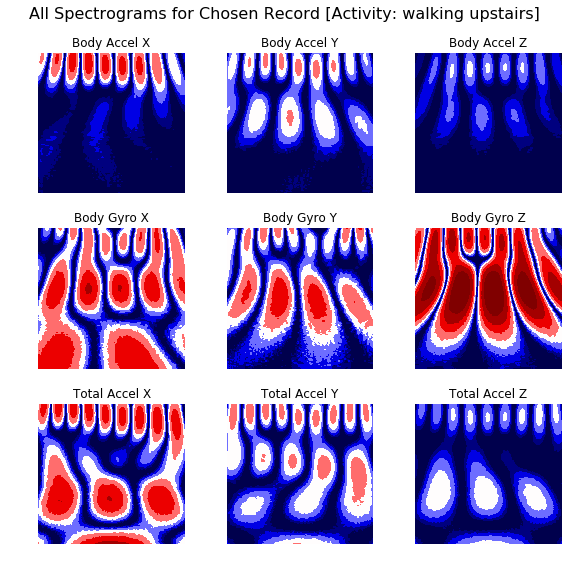

In [0]:
##############################################################################################
### EXTRACT AND PLOT SPECTROGRAMS FOR CHOSEN RECORD (EACH RECORDING CONSISTS OF 9 SENSORS) ###
##############################################################################################

t0 = 0
N = 128
f_s = 50
t_n = 2.56
T = t_n / N
dt = 1 / f_s
time = np.arange(0, N) * dt + t0

def plot_spectrogram(ax, time, signal, waveletname = 'morl', cmap = plt.cm.seismic):
    dt = time[1] - time[0]
    scales = np.arange(1, 128)
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    contourlevels = np.log2(levels)    
    ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)
    ax.invert_yaxis()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], -1)
    plt.axis('off')
    
record_num = 100
signals = train_signals[record_num, : , : ]
label = train_labels[record_num]
activity_name = activities_description[label]

axtitles = ['Body Accel X', 'Body Accel Y', 'Body Accel Z',
            'Body Gyro X', 'Body Gyro Y', 'Body Gyro Z',
            'Total Accel X', 'Total Accel Y', 'Total Accel Z']

fig = plt.figure(figsize = (8, 8))
suptitle = "All Spectrograms for Chosen Record [Activity: {}]"
fig.suptitle(suptitle.format(activity_name), fontsize=16)
for sig_comp in range(0,9):
    signal = signals[ : , sig_comp ]
    ax = fig.add_subplot(3, 3, sig_comp+1 )
    axtitle = axtitles[sig_comp]
    ax.set_title(axtitle, fontsize=12)
    #ax.set_xlabel('Seconds', fontsize=12)
    plot = plot_spectrogram(ax, time, signal)
fig.tight_layout()
plt.subplots_adjust(top=0.9, hspace=0.25)
fig.show()
print("Training Record Chosen: {}".format(record_num))

In [0]:
###############################################
### EXTRACT 9D SPECTROGRAMS FOR ALL RECORDS ###
###############################################

scales = range(1,128)
waveletname = 'morl'

#Take subset of data when training with CPU

#train_size = 250
train_size = len(train_signals)
print(train_size)
Xtrain_CWT = np.ndarray(shape=(train_size, 127, 127, 9))

for ii in range(0,train_size):
    if ii % 500 == 0:
        print(ii)
    for jj in range(0,9):
        signal = train_signals[ii, :, jj]
        coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
        coeff_ = coeff[:,:127]
        Xtrain_CWT[ii, :, :, jj] = coeff_

#test_size = 100
test_size = len(test_signals)
Xtest_CWT = np.ndarray(shape=(test_size, 127, 127, 9))
for ii in range(0,test_size):
    if ii % 250 == 0:
        print(ii)
    for jj in range(0,9):
        signal = test_signals[ii, :, jj]
        coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
        coeff_ = coeff[:,:127]
        Xtest_CWT[ii, :, :, jj] = coeff_

7352
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750


In [0]:
#####################################
### PREP DATA FOR CNN USING KERAS ###
#####################################

y_train = list(train_labels[:train_size])
y_test = list(test_labels[:test_size])

#Specify spectrogram image dimensions
img_x = 127
img_y = 127
img_z = 9
num_classes = 6

#reshape the data into a 4D tensor - (sample_number, x_img_size, y_img_size, num_channels)
#because the spectrograms are essentially grayscale, we only have a single channel - RGB colour images would have 3
input_shape = (img_x, img_y, img_z)

#convert the data to the right type
#x_train = x_train.reshape(x_train.shape[0], img_x, img_y, img_z)
#x_test = x_test.reshape(x_test.shape[0], img_x, img_y, img_z)
Xtrain_CWT = Xtrain_CWT.astype('float32')
Xtest_CWT = Xtest_CWT.astype('float32')

print('Xtrain_CWT shape:', Xtrain_CWT.shape)
print(Xtrain_CWT.shape[0], 'train samples')
print(Xtest_CWT.shape[0], 'test samples')

#convert class vectors to binary class matrices - this is for use in categorical_crossentropy loss below
Ytrain_CWT = keras.utils.to_categorical(y_train, num_classes)
Ytest_CWT = keras.utils.to_categorical(y_test, num_classes)

Xtrain_CWT shape: (7352, 127, 127, 9)
7352 train samples
2947 test samples


In [0]:
####################################################################
### BUILD CNN MODEL USING ONLY CWT FEATURES (SPECTROGRAM IMAGES) ###
####################################################################

#Specify hyperparameters (may need to tune to optimize performance)
def train_CNN(batch_size=64, epochs=100, lr=0.0001):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=input_shape)) 
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.025))
    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.025))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(0.50))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(lr=lr, decay=0.0, amsgrad=False),
              metrics=['accuracy'])

    model.fit(Xtrain_CWT, Ytrain_CWT, batch_size=batch_size, 
              epochs=epochs, verbose=1, 
              validation_data=(Xtest_CWT, Ytest_CWT), 
              callbacks=[history])

    train_score = model.evaluate(Xtrain_CWT, Ytrain_CWT, verbose=0)
    print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
    test_score = model.evaluate(Xtest_CWT, Ytest_CWT, verbose=0)
    print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

#Plot model performance over all epochs
def plot_epochs(epochs):
    fig, axarr = plt.subplots(figsize=(12,6), ncols=2)
    axarr[0].plot(range(1, epochs+1), history.history['acc'], label='train score')
    axarr[0].plot(range(1, epochs+1), history.history['val_acc'], label='test score')
    axarr[0].set_xlabel('Number of Epochs', fontsize=18)
    axarr[0].set_ylabel('Accuracy', fontsize=18)
    axarr[0].set_ylim([0,1])
    axarr[1].plot(range(1, epochs+1), history.history['acc'], label='train score')
    axarr[1].plot(range(1, epochs+1), history.history['val_acc'], label='test score')
    axarr[1].set_xlabel('Number of Epochs', fontsize=18)
    axarr[1].set_ylabel('Accuracy', fontsize=18)
    axarr[1].set_ylim([0.75,1])
    plt.legend()
    plt.show()

W0803 17:37:51.424744 140679515445120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0803 17:37:51.428132 140679515445120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0803 17:37:51.442710 140679515445120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0803 17:37:51.473352 140679515445120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0803 17:37:51.475896 140679515445120 deprecation_wrapp

Train on 7352 samples, validate on 2947 samples
Epoch 1/100
7352/7352 [==============================] - 21s 3ms/step - loss: 0.5459 - acc: 0.8689 - val_loss: 0.2991 - val_acc: 0.9057
Epoch 2/100
7352/7352 [==============================] - 14s 2ms/step - loss: 0.1383 - acc: 0.9468 - val_loss: 0.3391 - val_acc: 0.9006
Epoch 3/100
7352/7352 [==============================] - 14s 2ms/step - loss: 0.1334 - acc: 0.9502 - val_loss: 0.4187 - val_acc: 0.8979
Epoch 4/100
7352/7352 [==============================] - 14s 2ms/step - loss: 0.1272 - acc: 0.9555 - val_loss: 0.8123 - val_acc: 0.8772
Epoch 5/100
7352/7352 [==============================] - 14s 2ms/step - loss: 0.1086 - acc: 0.9600 - val_loss: 0.4889 - val_acc: 0.9114
Epoch 6/100
7352/7352 [==============================] - 14s 2ms/step - loss: 0.0960 - acc: 0.9642 - val_loss: 0.3812 - val_acc: 0.9226
Epoch 7/100
7352/7352 [==============================] - 14s 2ms/step - loss: 0.0905 - acc: 0.9689 - val_loss: 0.5279 - val_acc: 0.9253


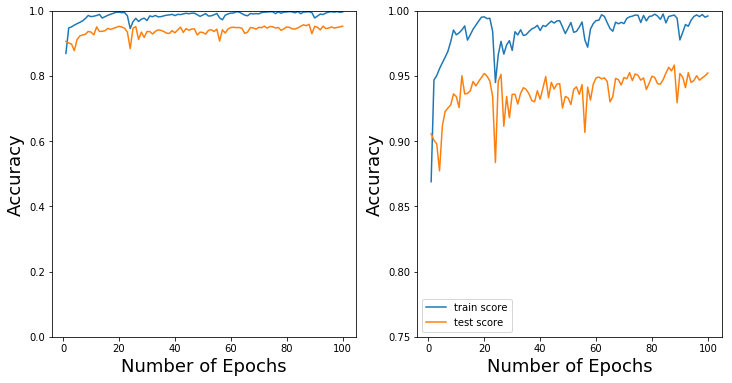

In [0]:
######################
###TRAIN CNN MODEL ###
######################

train_CNN(batch_size=64, epochs=100, lr=0.001)
plot_epochs(epochs=100)